In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

In [154]:
from provisioning_model.functions.resource_flow import get_country_data, draw_arrow

In [322]:
all_in_one = pd.read_csv('../data/all_in_one.csv', index_col=0)
all_in_one_no_inf = all_in_one.replace([np.inf, -np.inf], np.nan)
wdi_outcomes = pd.read_csv('../data/wdi_outcomes.csv')
wdi_outcomes_no_inf = wdi_outcomes.replace([np.inf, -np.inf], np.nan)
wdi_realms = pd.read_csv('../data/wdi_realms.csv')
wdi_realms_no_inf = wdi_realms.replace([np.inf, -np.inf], np.nan)
un_mat_flows = pd.read_csv("../data/un_mat_flows.csv")

In [330]:
canada_2014 = get_country_data(all_in_one_no_inf, wdi_outcomes_no_inf, wdi_realms_no_inf, un_mat_flows, "Canada", 2014)
liberia_2014 = get_country_data(all_in_one_no_inf, wdi_outcomes_no_inf, wdi_realms_no_inf, un_mat_flows, "Liberia",
                                2014)

In [341]:
agriculture, industry, services, grosscapital, unemployed, wealth, lifeexpectancy, education, govconsum, marketcap, houseconsum, energy, mfootprint = ethiopia_2014.values()

In [342]:
# Arrays to define the structure (update as needed)
all_x_coords = [[0.125, 0.375, 0.625, 0.875], [0.125, 0.375, 0.625, 0.875], [0.25, 0.5, 0.75],
                [0.125, 0.375, 0.625, 0.875],
                [0.125, 0.375, 0.625, 0.875]
                ]
all_x_axis_ticks = [['Worker', 'Capital', 'Energy', 'Resource'], ['State', 'Market', 'Household', 'Commons'],
                    ['Agriculture', 'Industry', 'Services'], ['Core', 'Foundational', 'Overlooked', 'Competitive'],
                    ['Accumulation', 'Needs', 'HDI', 'Waste']
                    ]
all_y_axis_ticks = [['extraction'], ['realms'], ['industry'], ['foundational'], ['dissipation']]
all_sizes = [[unemployed, wealth, energy, 0.1], [govconsum, marketcap, houseconsum, 0.1],
             [agriculture, industry, services],
             [0.1, 0.1, 0.1, 0.1],
             [grosscapital, lifeexpectancy, education, mfootprint]]

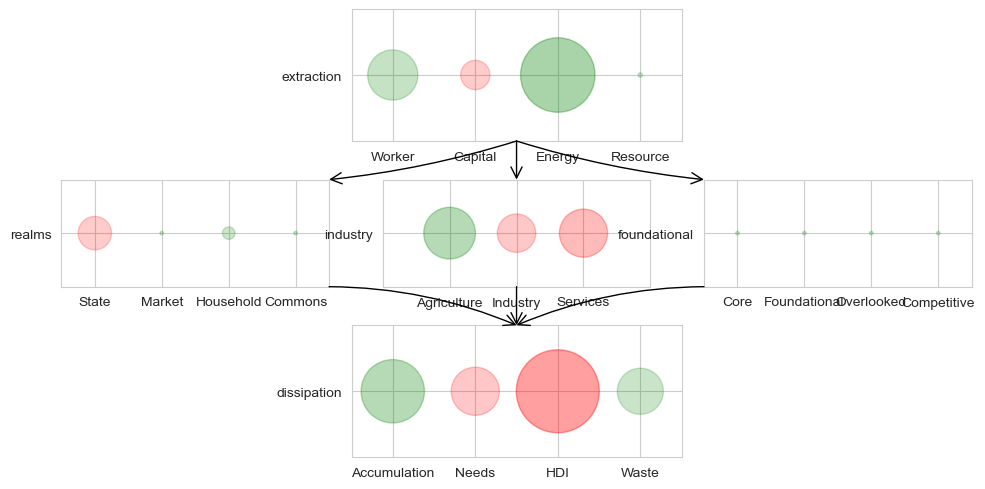

In [343]:
# Create a figure with a defined gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)

# Creating the first and the third main subplot
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[2, 0])

# Creating a nested gridspec for the second main subplot
gs_nested = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1])

# Creating the three smaller subplots within the second main subplot
ax3 = plt.subplot(gs_nested[0])
ax4 = plt.subplot(gs_nested[1])
ax5 = plt.subplot(gs_nested[2])

all_axes = [ax1, ax3, ax4, ax5, ax2]  # Reordered to match the structure

color_transformations = {
    (0, 0): lambda color: 'green' if color == 'red' else 'red',  # Reverse color for the first circle in the first axis
    (0, 2): lambda color: 'green' if color == 'red' else 'red',
    (4, 3): lambda color: 'green' if color == 'red' else 'red',
    # (2, 2): lambda color: 'blue'  # Change to blue for the third circle in the third axis
    # Add more transformations as needed
}

for ax_index, ax in enumerate(all_axes):
    x_coords = all_x_coords[ax_index]
    x_axis_ticks = all_x_axis_ticks[ax_index]
    y_axis_ticks = all_y_axis_ticks[ax_index]
    sizes = all_sizes[ax_index]

    for circle_index, (x, size, color) in enumerate(zip(x_coords, sizes, x_axis_ticks)):
        if size < 0:
            color = 'red'
        else:
            color = 'green'

        if (ax_index, circle_index) in color_transformations:
            color = color_transformations[(ax_index, circle_index)](color)

        if np.isnan(size):
            alpha = 0.2
            radius = 0.1 / 15
        else:
            alpha = max(abs(size) / 5, 0.2)
            radius = abs(size) / 15

        circle = plt.Circle((x, 0.5), radius=radius, color=color, alpha=alpha)
        ax.set_ylim(0.3, 0.7)
        ax.add_patch(circle)
        ax.set_aspect('equal', 'box')
        ax.set_xticks(x_coords)
        ax.set_xticklabels(x_axis_ticks)
        ax.set_yticks([0.5])
        ax.set_yticklabels(y_axis_ticks)

draw_arrow(ax1, 0.5, ax4, 0.5, linewidth=1, y1=0.3, y2=0.7)
draw_arrow(ax1, 0.5, ax5, 0, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=0.05")
draw_arrow(ax1, 0.5, ax3, 1, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=-0.05")

draw_arrow(ax3, 1, ax2, 0.5, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=-0.1")
draw_arrow(ax5, 0, ax2, 0.5, linewidth=1, y1=0.3, y2=0.7, connectionstyle="arc3,rad=0.1")
draw_arrow(ax4, 0.5, ax2, 0.5, linewidth=1, y1=0.3, y2=0.7)

plt.tight_layout()
plt.show()